# 🎯 傳統監督式模型比較與資料不平衡重抽樣策略評估  
## Traditional Supervised Model Comparison with Resampling Strategies

本 Notebook 探討並比較了多種監督式機器學習模型（如 Logistic Regression、Random Forest、LightGBM、CatBoost 等）於不平衡資料集上的分類效能。  
同時結合 SMOTE、ADASYN、SMOTEENN 等重抽樣策略，分析在不同資料分布條件下模型表現的變化。

This notebook evaluates multiple traditional supervised learning models on imbalanced classification tasks.  
It integrates various resampling methods to enhance model performance and compares their effect on key metrics like F1, Recall, and ROC AUC.

## 📘 分析流程步驟

1. **資料前處理**  
   - 特徵工程、標準化與類別轉換處理

2. **模型定義與訓練**  
   - 使用多種模型（LogisticRegression、RandomForest、LightGBM、CatBoost、SVC、KNN、MLP）

3. **不平衡處理方法比較**
   - 使用 SMOTE、SVMSMOTE、ADASYN、SMOTEENN、SMOTETomek 等策略  
   - 比較 Precision、Recall、F1、ROC AUC 表現

4. **結果視覺化與比較**
   - 混淆矩陣
   - PR Curve / ROC Curve / F1 vs Threshold
   - 各指標橫向條形圖（Barplot）

5. **最佳模型挑選邏輯**
   - 優先條件：PR AUC ≥ 0.6 且 ROC AUC ≥ 0.7  
   - 若無人達標，改從 ROC AUC ≥ 0.7 中選 Recall 最佳
   - 最終顯示最佳模型與關鍵指標

## ✅ 結論與推薦

- 綜合各項評估指標後，最佳模型為：**`{best_model}`**
- 選擇依據：{note}
- 評估指標如下：
  - PR AUC：{model_scores[best_model]['pr_auc']:.4f}
  - ROC AUC：{model_scores[best_model]['roc_auc']:.4f}
  - Recall：{model_scores[best_model]['recall']:.4f}

🔍 若無模型同時達標 PR AUC 與 ROC AUC，可考慮：
- 放寬門檻或進一步調整模型參數
- 強化資料清洗或特徵擴增

## 使用 SecomPreprocessor 前處理並建立三種模型

In [ ]:
## 使用 SecomPreprocessor 前處理資料

# from SECOM_data_process import SecomPreprocessor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
import lightgbm as lgb
from catboost import CatBoostClassifier
import shap
import matplotlib.pyplot as plt
import joblib

# === 讀取資料 ===
raw_data = pd.read_csv('/Users/ching/Documents/SideProject/data/secom/secom.data', delim_whitespace=True, header=None)
labels = pd.read_csv('/Users/ching/Documents/SideProject/data/secom/secom_labels.data', delim_whitespace=True, header=None)
raw_data.columns = [f"sensor_{i+1}" for i in range(raw_data.shape[1])]
X = raw_data.copy()
y = (labels[0] == 1).astype(int)

# === 分割資料 ===
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# === 前處理（內含 SMOTE 與特徵處理）===
import sys
from pathlib import Path
PROJECT_ROOT = Path.cwd().parent.parent  # 根據你的資料夾結構調整
print(PROJECT_ROOT)
sys.path.append(str(PROJECT_ROOT))
from preprocessing.secom_preprocessor import Preprocessor
from preprocessing.balancer import apply_smoteenn
pre = Preprocessor()
X_train_proc = pre.fit_transform(X_train)
X_test_proc = pre.transform(X_test)

# 儲存前處理器
joblib.dump(pre, "secom_preprocessor.pkl")

# X_train_proc,y_train = apply_smoteenn(X_train_proc, y_train, random_state=42)


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/zc/bg3g21_j7yq8y2dpzx88kk4w0000gn/T/ipykernel_25045/1247248445.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  raw_data = pd.read_csv('/Users/ching/Documents/SideProject/data/secom/secom.data', delim_whitespace=True, header=None)
/var/folders/zc/bg3g21_j7yq8y2dpzx88kk4w0000gn/T/ipykernel_25045/1247248445.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  labels = pd.read_csv('/Users/ching/Documents/SideProject/data/secom/secom_labels.data', delim_whitespace=True, header=None)


/Users/ching/Documents/SideProject/industrial-fault-prediction
▶ Imputing missing values with mean...
▶ Handling outliers using IQR clipping...
▶ Removing near-zero variance features...
✅ Remaining features after variance filter: 590
▶ Removing highly correlated features (Pearson > 0.95)...
✅ Remaining features after correlation filter: 590
▶ Scaling features...


['secom_preprocessor.pkl']

## 🧠 模型訓練函式定義：train_models_and_get_results_verbose

以下為主要的模型訓練函式，支援多模型訓練、自動預測與記錄分類報告（含 IsolationForest 非監督模型）。
每個模型訓練過程會顯示：
- 模型名稱與分隔標題
- 訓練與預測時間
- 分類報告（Precision / Recall / F1）

This function trains and evaluates multiple models including tree-based, linear, and neural classifiers.
It prints:
- Section headers for each model
- Training duration
- Classification report for each

In [2]:
import time
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report

def train_models_and_get_results_verbose(X_train_proc, y_train, X_test_proc, y_test):
    model_dict = {
        "LogisticRegression": LogisticRegression(class_weight='balanced', max_iter=1000),
        "RandomForest": RandomForestClassifier(class_weight='balanced', random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "LightGBM": LGBMClassifier(class_weight='balanced', random_state=42),
        "CatBoost": CatBoostClassifier(verbose=0, random_seed=42, scale_pos_weight=5),
        "SVC": SVC(probability=True, class_weight='balanced', random_state=42),
        "KNN": KNeighborsClassifier(),
        "MLP": MLPClassifier(max_iter=500, random_state=42),
        "IsolationForest": IsolationForest(contamination=0.1, random_state=42)
    }

    results = {}
    reports = {}

    for name, model in model_dict.items():
        print("\n" + "=" * 60)
        print(f"🚀 開始訓練模型：{name}")
        print("=" * 60)

        start = time.time()

        if name == "IsolationForest":
            model.fit(X_train_proc)
            y_pred = (model.predict(X_test_proc) == -1).astype(int)
            y_proba = y_pred
        else:
            model.fit(X_train_proc, y_train)
            y_proba = model.predict_proba(X_test_proc)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test_proc)
            y_pred = (y_proba > 0.5).astype(int)

        end = time.time()
        duration = end - start

        print(f"⏱️ 訓練與預測耗時：{duration:.2f} 秒")
        print(f"\n📊 {name} 分類報告摘要：")
        print(classification_report(y_test, y_pred, target_names=["Non-Fault", "Fault"]))

        results[name] = {
            "model": model,
            "y_pred": y_pred,
            "y_proba": y_proba
        }

        reports[name] = classification_report(y_test, y_pred, target_names=["Non-Fault", "Fault"], output_dict=True)

    return results, reports

## 📈 模型評估與視覺化函式：evaluate_models_and_plot

此函式會對所有監督式模型進行以下評估與圖表輸出：
- 混淆矩陣（每個模型）
- Precision-Recall Curve
- ROC Curve
- F1 分數與 Threshold 的關係
- 自動找出最佳模型（PR AUC 達標後選 Recall 最佳）

This function visualizes classification results for each model and compares their performance using key metrics.

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, precision_recall_curve, roc_curve, auc
)
import pandas as pd

def evaluate_models_and_plot(results, y_test, X_columns):
    valid_models = [n for n in results if n != "IsolationForest"]

    # 模型評估總表
    df_results = pd.DataFrame([
        {
            "Model": name,
            "Precision": precision_score(y_test, res["y_pred"]),
            "Recall": recall_score(y_test, res["y_pred"]),
            "F1-Score": f1_score(y_test, res["y_pred"]),
            "ROC AUC": roc_auc_score(y_test, res["y_proba"])
        }
        for name, res in results.items() if name != "IsolationForest"
    ]).round(3)
    print("\n📊 模型總表：")
    print(df_results)

    # 混淆矩陣
    for name in valid_models:
        cm = confusion_matrix(y_test, results[name]["y_pred"])
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                    xticklabels=["Non-Fault", "Fault"],
                    yticklabels=["Non-Fault", "Fault"])
        plt.title(f"Confusion Matrix - {name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()

    # 三圖合併
    plt.figure(figsize=(18, 5))

    # PR Curve
    plt.subplot(1, 3, 1)
    for name in valid_models:
        precision, recall, _ = precision_recall_curve(y_test, results[name]["y_proba"])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"{name} (AUC={pr_auc:.3f})")
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.legend()

    # ROC Curve
    plt.subplot(1, 3, 2)
    for name in valid_models:
        fpr, tpr, _ = roc_curve(y_test, results[name]["y_proba"])
        roc_auc = roc_auc_score(y_test, results[name]["y_proba"])
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title("ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.grid(True)
    plt.legend()

    # F1 vs Threshold
    plt.subplot(1, 3, 3)
    for name in valid_models:
        precision, recall, thresholds = precision_recall_curve(y_test, results[name]["y_proba"])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
        plt.plot(thresholds, f1_scores[:-1], label=name)
    plt.title("F1 vs Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # 模型挑選條件與邏輯
    PR_AUC_THRESHOLD = 0.6
    ROC_AUC_THRESHOLD = 0.7
    RECALL_THRESHOLD = 0.8
    model_scores = {}

    for name in valid_models:
        precision, recall, _ = precision_recall_curve(y_test, results[name]["y_proba"])
        pr_auc = auc(recall, precision)
        recall_val = recall_score(y_test, results[name]["y_pred"])
        roc_auc = roc_auc_score(y_test, results[name]["y_proba"])
        avg_proba = results[name]["y_proba"].mean()
        Precision = df_results['Precision'][df_results['Model'] == name].values[0]
        model_scores[name] = {
            "pr_auc": pr_auc,
            "recall": recall_val,
            "roc_auc": roc_auc,
            "avg_proba": avg_proba,
            "Precision": Precision
        }

    qualified_full = {
        name: score for name, score in model_scores.items()
        if score["pr_auc"] >= PR_AUC_THRESHOLD and score["roc_auc"] >= ROC_AUC_THRESHOLD
    }

    qualified_partial = {
        name: score for name, score in model_scores.items()
        if score["pr_auc"] < PR_AUC_THRESHOLD and
           score["roc_auc"] >= ROC_AUC_THRESHOLD and
           score["recall"] >= RECALL_THRESHOLD
    }

    fallback = {name: score for name, score in model_scores.items()}

    if qualified_full:
        best_model = max(qualified_full.items(), key=lambda x: x[1]["recall"])[0]
        note = "🎯 PR AUC 與 ROC AUC 達標，選 Recall 最佳"
    elif qualified_partial:
        best_model = max(qualified_partial.items(), key=lambda x: x[1]["Precision"])[0]
        note = "🟡 PR AUC 未達標，但 ROC AUC 與 Recall 達標 → 選預測機率最高者"
    else:
        best_model = max(fallback.items(), key=lambda x: x[1]["recall"])[0]
        note = "⚠️ 僅 Recall 有達標 → 選 Recall 最佳"

    print(f"\n🏆 最佳模型：{best_model}（{note}）")
    for k, v in model_scores[best_model].items():
        print(f"🔹 {k}: {v:.4f}")

    return df_results, model_scores, best_model, note

## 📊 條形圖視覺化指標比較：plot_top_metrics

本函式會根據模型評估結果 `df_results`，分別繪製以下指標的比較長條圖：
- F1-Score
- Recall
- Precision

每張圖會排序模型表現，並以 🔝 標示最佳模型，快速掌握誰在該指標表現最好。

In [18]:
def plot_top_metrics(df_results):
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set(style="whitegrid")
    metrics = ["F1-Score", "Recall", "Precision"]
    colors = {"F1-Score": "Blues_d", "Recall": "Greens_d", "Precision": "Oranges_d"}

    for metric in metrics:
        plt.figure(figsize=(10, 4))
        data_sorted = df_results.sort_values(metric, ascending=False).copy()
        best_model = data_sorted.iloc[0]["Model"]
        best_value = data_sorted.iloc[0][metric]

        ax = sns.barplot(x=metric, y="Model", data=data_sorted, palette=colors[metric])
        plt.title(f"{metric} Comparison by Model")

        for i, (value, label) in enumerate(zip(data_sorted[metric], data_sorted["Model"])):
            if label == best_model:
                ax.text(value + 0.01, i, "🔝", color="black", va="center", fontweight="bold")

        plt.xlim(0, 1)
        plt.tight_layout()
        plt.show()

# 監督式模型 with class_weight

In [19]:
results, reports = train_models_and_get_results_verbose(X_train_proc, y_train, X_test_proc, y_test)


🚀 開始訓練模型：LogisticRegression
⏱️ 訓練與預測耗時：0.08 秒

📊 LogisticRegression 分類報告摘要：
              precision    recall  f1-score   support

   Non-Fault       0.94      0.89      0.91       293
       Fault       0.09      0.14      0.11        21

    accuracy                           0.84       314
   macro avg       0.51      0.52      0.51       314
weighted avg       0.88      0.84      0.86       314


🚀 開始訓練模型：RandomForest
⏱️ 訓練與預測耗時：0.62 秒

📊 RandomForest 分類報告摘要：
              precision    recall  f1-score   support

   Non-Fault       0.93      1.00      0.97       293
       Fault       0.00      0.00      0.00        21

    accuracy                           0.93       314
   macro avg       0.47      0.50      0.48       314
weighted avg       0.87      0.93      0.90       314


🚀 開始訓練模型：XGBoost


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

⏱️ 訓練與預測耗時：0.28 秒

📊 XGBoost 分類報告摘要：
              precision    recall  f1-score   support

   Non-Fault       0.93      1.00      0.97       293
       Fault       0.00      0.00      0.00        21

    accuracy                           0.93       314
   macro avg       0.47      0.50      0.48       314
weighted avg       0.87      0.93      0.90       314


🚀 開始訓練模型：LightGBM
[LightGBM] [Info] Number of positive: 83, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59899
[LightGBM] [Info] Number of data points in the train set: 1253, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

⏱️ 訓練與預測耗時：0.73 秒

📊 LightGBM 分類報告摘要：
              precision    recall  f1-score   support

   Non-Fault       0.93      1.00      0.96       293
       Fault       0.00      0.00      0.00        21

    accuracy                           0.93       314
   macro avg       0.47      0.50      0.48       314
weighted avg       0.87      0.93      0.90       314


🚀 開始訓練模型：CatBoost
⏱️ 訓練與預測耗時：6.23 秒

📊 CatBoost 分類報告摘要：
              precision    recall  f1-score   support

   Non-Fault       0.93      1.00      0.97       293
       Fault       0.00      0.00      0.00        21

    accuracy                           0.93       314
   macro avg       0.47      0.50      0.48       314
weighted avg       0.87      0.93      0.90       314


🚀 開始訓練模型：SVC


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

⏱️ 訓練與預測耗時：0.39 秒

📊 SVC 分類報告摘要：
              precision    recall  f1-score   support

   Non-Fault       0.94      1.00      0.97       293
       Fault       1.00      0.05      0.09        21

    accuracy                           0.94       314
   macro avg       0.97      0.52      0.53       314
weighted avg       0.94      0.94      0.91       314


🚀 開始訓練模型：KNN
⏱️ 訓練與預測耗時：0.00 秒

📊 KNN 分類報告摘要：
              precision    recall  f1-score   support

   Non-Fault       0.94      0.99      0.96       293
       Fault       0.43      0.14      0.21        21

    accuracy                           0.93       314
   macro avg       0.68      0.56      0.59       314
weighted avg       0.91      0.93      0.91       314


🚀 開始訓練模型：MLP
⏱️ 訓練與預測耗時：1.58 秒

📊 MLP 分類報告摘要：
              precision    recall  f1-score   support

   Non-Fault       0.94      0.99      0.96       293
       Fault       0.40      0.10      0.15        21

    accuracy                           0.93       314
 


📊 模型總表：
                Model  Precision  Recall  F1-Score  ROC AUC
0  LogisticRegression      0.086   0.143     0.107    0.661
1        RandomForest      0.000   0.000     0.000    0.740
2             XGBoost      0.000   0.000     0.000    0.679
3            LightGBM      0.000   0.000     0.000    0.740
4            CatBoost      0.000   0.000     0.000    0.775
5                 SVC      1.000   0.048     0.091    0.705
6                 KNN      0.429   0.143     0.214    0.761
7                 MLP      0.400   0.095     0.154    0.648


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

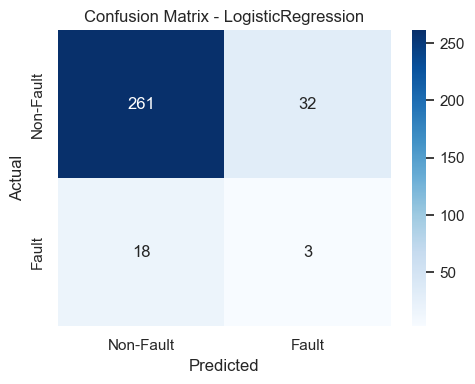

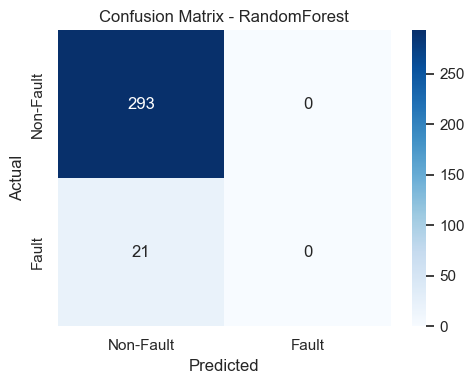

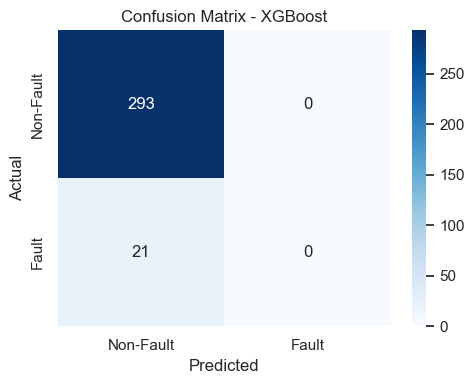

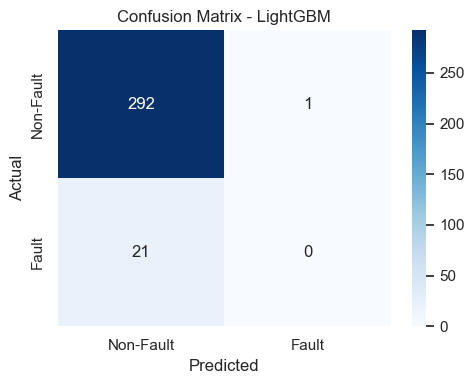

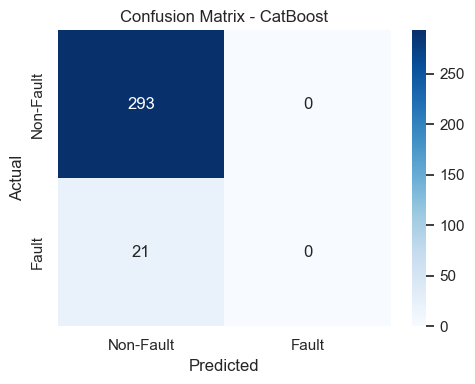

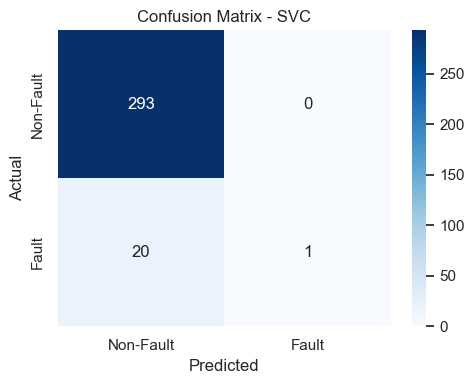

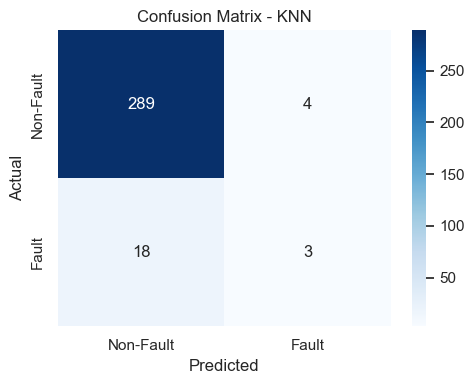

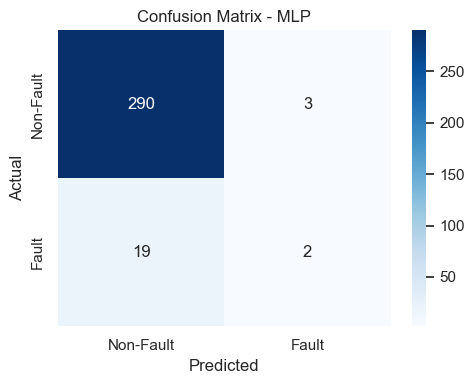

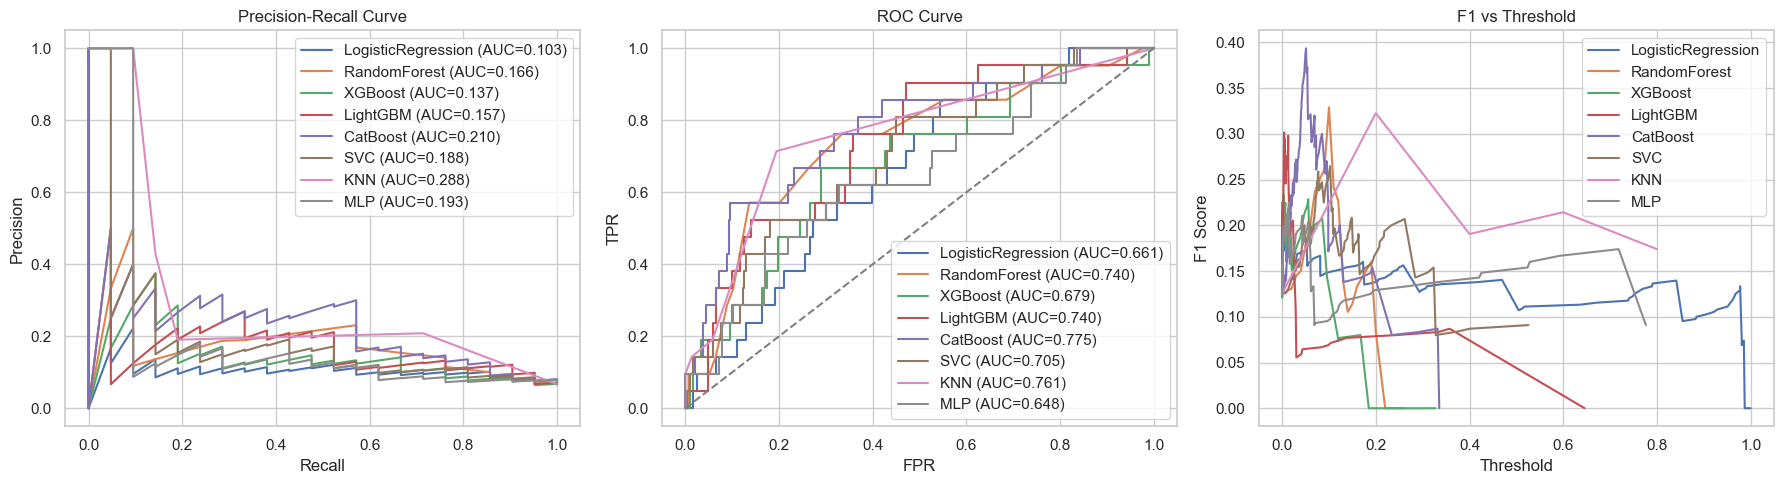


🏆 最佳模型：LogisticRegression（⚠️ 僅 Recall 有達標 → 選 Recall 最佳）
🔹 pr_auc: 0.1027
🔹 recall: 0.1429
🔹 roc_auc: 0.6613
🔹 avg_proba: 0.1181
🔹 Precision: 0.0860


In [20]:
df_results, model_scores, best_model, note = evaluate_models_and_plot(results, y_test, X.columns)

/var/folders/zc/bg3g21_j7yq8y2dpzx88kk4w0000gn/T/ipykernel_25045/1983717171.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=metric, y="Model", data=data_sorted, palette=colors[metric])
/var/folders/zc/bg3g21_j7yq8y2dpzx88kk4w0000gn/T/ipykernel_25045/1983717171.py:23: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) Arial.
  plt.tight_layout()
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


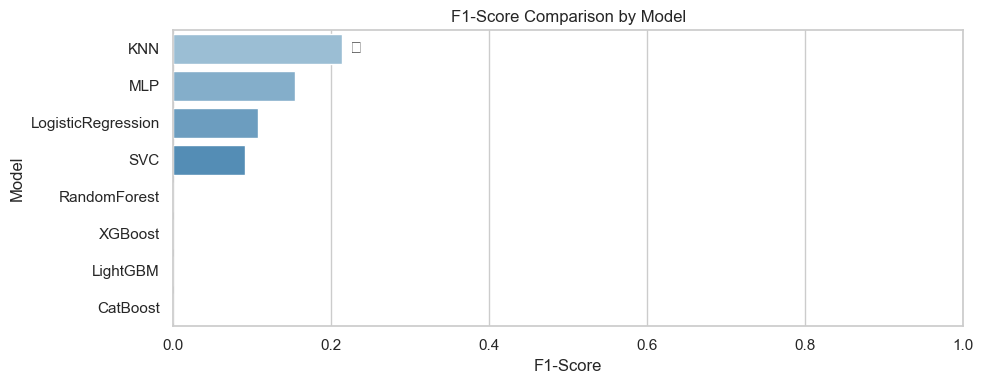

/var/folders/zc/bg3g21_j7yq8y2dpzx88kk4w0000gn/T/ipykernel_25045/1983717171.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=metric, y="Model", data=data_sorted, palette=colors[metric])
/var/folders/zc/bg3g21_j7yq8y2dpzx88kk4w0000gn/T/ipykernel_25045/1983717171.py:23: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) Arial.
  plt.tight_layout()
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


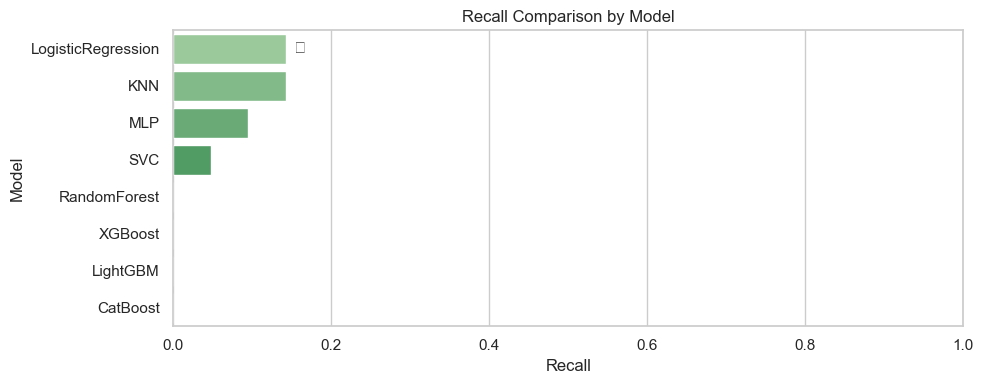

/var/folders/zc/bg3g21_j7yq8y2dpzx88kk4w0000gn/T/ipykernel_25045/1983717171.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=metric, y="Model", data=data_sorted, palette=colors[metric])
/var/folders/zc/bg3g21_j7yq8y2dpzx88kk4w0000gn/T/ipykernel_25045/1983717171.py:23: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) Arial.
  plt.tight_layout()
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


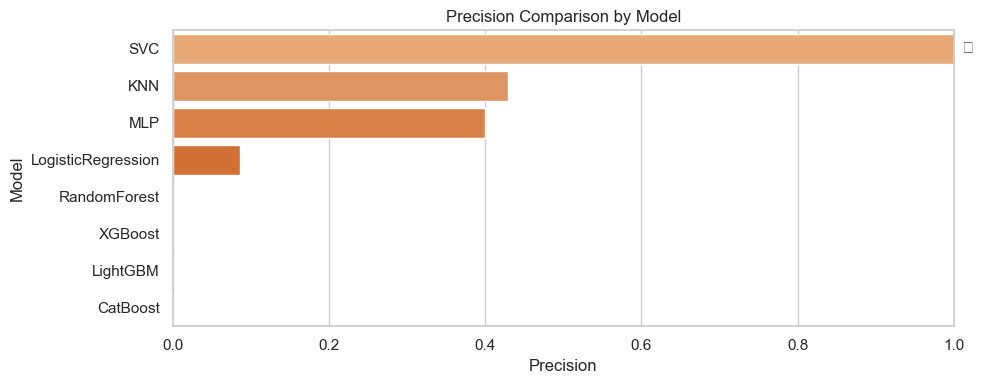

In [21]:
plot_top_metrics(df_results)

## 🔁 資料不平衡處理方法比較：compare_resampling_strategies()

此函式會自動比較以下 7 種不平衡資料處理方法在分類任務中的效果：

- SMOTE
- SVMSMOTE
- ADASYN
- BorderlineSMOTE
- KMeansSMOTE
- SMOTEENN（SMOTE + ENN）
- SMOTETomek（SMOTE + Tomek Links）

每種方法會：
1. 使用訓練資料進行重抽樣
2. 使用指定的分類器進行模型訓練
3. 預測測試集並計算：
   - Precision
   - Recall
   - F1-Score
   - ROC AUC
4. 回傳整體比較表格 `df_compare`，以及每個方法的分類報告 `results_detail`

---

📌 可用於選擇最佳的重抽樣策略，搭配視覺化圖表（如 `plot_top_metrics`）進一步評估。

In [22]:


from imblearn.over_sampling import (
    SMOTE, SVMSMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE
)
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, classification_report
)
import pandas as pd

def compare_resampling_strategies(X_train_proc, y_train, X_test_proc, y_test, model):
    """
    比較多種不平衡資料處理方法，包含錯誤處理機制。
    回傳：df_compare（各指標表格），results_detail（分類報告）

    參數：
    - X_train_proc, y_train: 前處理後的訓練資料
    - X_test_proc, y_test: 測試資料
    - model: 要套用的分類器（需有 fit/predict_proba）

    回傳：
    - df_compare: 各 Resampler 的 Precision、Recall、F1、ROC AUC 表格
    - results_detail: 各模型的 classification_report 詳細結果
    """

    resampler_dict = {
        "SMOTE": SMOTE(random_state=42),
        "SVMSMOTE": SVMSMOTE(random_state=42),
        "ADASYN": ADASYN(random_state=42),
        "BorderlineSMOTE": BorderlineSMOTE(random_state=42),
        "KMeansSMOTE": KMeansSMOTE(random_state=42),
        "SMOTEENN": SMOTEENN(random_state=42),
        "SMOTETomek": SMOTETomek(random_state=42)
    }

    results_summary = []
    results_detail = {}

    for method_name, sampler in resampler_dict.items():
        print(f"\n=== 🔁 重抽樣策略：{method_name} ===")

        try:
            # 1. 嘗試重抽樣
            X_resampled, y_resampled = sampler.fit_resample(X_train_proc, y_train)
        except Exception as e:
            print(f"⚠️ {method_name} 發生錯誤，略過此方法：{e}")
            continue

        try:
            # 2. 模型訓練與預測
            model.fit(X_resampled, y_resampled)
            y_proba = model.predict_proba(X_test_proc)[:, 1]
            y_pred = (y_proba > 0.5).astype(int)

            # 3. 評估指標
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_proba)

            # 4. 儲存結果
            results_summary.append({
                "Resampler": method_name,
                "Precision": precision,
                "Recall": recall,
                "F1-Score": f1,
                "ROC AUC": roc_auc
            })

            results_detail[method_name] = classification_report(
                y_test, y_pred,
                target_names=["Non-Fault", "Fault"],
                output_dict=True
            )

        except Exception as e:
            print(f"❌ {method_name} 評估過程中發生錯誤：{e}")
            continue

    df_compare = pd.DataFrame(results_summary).round(3)
    return df_compare, results_detail

### 固定LGBMClassifier模型，比較多種不平衡資料處理方法


### 🏆 最佳策略：SMOTEENN（⚠️ 無 F1 達標，選 Recall 最佳）

In [23]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(class_weight='balanced', random_state=42)

df_compare, detail = compare_resampling_strategies(
    X_train_proc, y_train,
    X_test_proc, y_test,
    model=model
)


=== 🔁 重抽樣策略：SMOTE ===
[LightGBM] [Info] Number of positive: 1170, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70650
[LightGBM] [Info] Number of data points in the train set: 2340, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ching/.pyenv/versions/3.10.13/


=== 🔁 重抽樣策略：SVMSMOTE ===
[LightGBM] [Info] Number of positive: 1170, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70259
[LightGBM] [Info] Number of data points in the train set: 2340, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ching/.pyenv/versions/3.10.13/


=== 🔁 重抽樣策略：ADASYN ===
[LightGBM] [Info] Number of positive: 1148, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70663
[LightGBM] [Info] Number of data points in the train set: 2318, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== 🔁 重抽樣策略：BorderlineSMOTE ===
[LightGBM] [Info] Number of positive: 1170, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70618
[LightGBM] [Info] Number of data points in the train set: 2340, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ching/.pyenv/versions/3.10.13/


=== 🔁 重抽樣策略：KMeansSMOTE ===
⚠️ KMeansSMOTE 發生錯誤，略過此方法：No clusters found with sufficient samples of class 1. Try lowering the cluster_balance_threshold or increasing the number of clusters.

=== 🔁 重抽樣策略：SMOTEENN ===
[LightGBM] [Info] Number of positive: 1170, number of negative: 139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70596
[LightGBM] [Info] Number of data points in the train set: 1309, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== 🔁 重抽樣策略：SMOTETomek ===
[LightGBM] [Info] Number of positive: 1170, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70650
[LightGBM] [Info] Number of data points in the train set: 2340, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ching/.pyenv/versions/3.10.13/

In [24]:
df_compare, detail

(         Resampler  Precision  Recall  F1-Score  ROC AUC
 0            SMOTE      0.000   0.000     0.000    0.669
 1         SVMSMOTE      0.000   0.000     0.000    0.706
 2           ADASYN      0.000   0.000     0.000    0.679
 3  BorderlineSMOTE      0.000   0.000     0.000    0.704
 4         SMOTEENN      0.123   0.857     0.216    0.722
 5       SMOTETomek      0.000   0.000     0.000    0.669,
 {'SMOTE': {'Non-Fault': {'precision': 0.9331210191082803,
    'recall': 1.0,
    'f1-score': 0.9654036243822076,
    'support': 293.0},
   'Fault': {'precision': 0.0,
    'recall': 0.0,
    'f1-score': 0.0,
    'support': 21.0},
   'accuracy': 0.9331210191082803,
   'macro avg': {'precision': 0.46656050955414013,
    'recall': 0.5,
    'f1-score': 0.4827018121911038,
    'support': 314.0},
   'weighted avg': {'precision': 0.8707148363016756,
    'recall': 0.9331210191082803,
    'f1-score': 0.900838413834353,
    'support': 314.0}},
  'SVMSMOTE': {'Non-Fault': {'precision': 0.933121019

### 選出最好的resampler方法

In [25]:
def select_best_resampler(df_compare, f1_threshold=0.7):
    qualified = df_compare[df_compare["F1-Score"] >= f1_threshold]
    if not qualified.empty:
        best_row = qualified.sort_values("Recall", ascending=False).iloc[0]
        note = "🎯 F1 達標後，Recall 最佳"
    else:
        best_row = df_compare.sort_values("Recall", ascending=False).iloc[0]
        note = "⚠️ 無 F1 達標，選 Recall 最佳"
    return best_row, note

In [26]:
best, reason = select_best_resampler(df_compare)
print(f"\n🏆 最佳策略：{best['Resampler']}（{reason}）\n")
print(best)


🏆 最佳策略：SMOTEENN（⚠️ 無 F1 達標，選 Recall 最佳）

Resampler    SMOTEENN
Precision       0.123
Recall          0.857
F1-Score        0.216
ROC AUC         0.722
Name: 4, dtype: object


# 監督式模型 with class_weight and SMOTEENN

In [27]:
# SMOTEENN 重抽樣
smoteenn = SMOTEENN(random_state=42)
X_train_bal, y_train_bal = smoteenn.fit_resample(X_train_proc, y_train)

In [28]:
results, reports = train_models_and_get_results_verbose(X_train_bal, y_train_bal, X_test_proc, y_test)


🚀 開始訓練模型：LogisticRegression
⏱️ 訓練與預測耗時：0.02 秒

📊 LogisticRegression 分類報告摘要：
              precision    recall  f1-score   support

   Non-Fault       0.96      0.63      0.76       293
       Fault       0.11      0.67      0.19        21

    accuracy                           0.63       314
   macro avg       0.54      0.65      0.48       314
weighted avg       0.91      0.63      0.72       314


🚀 開始訓練模型：RandomForest
⏱️ 訓練與預測耗時：0.75 秒

📊 RandomForest 分類報告摘要：
              precision    recall  f1-score   support

   Non-Fault       0.99      0.25      0.39       293
       Fault       0.08      0.95      0.15        21

    accuracy                           0.29       314
   macro avg       0.53      0.60      0.27       314
weighted avg       0.93      0.29      0.38       314


🚀 開始訓練模型：XGBoost


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:23:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


⏱️ 訓練與預測耗時：0.21 秒

📊 XGBoost 分類報告摘要：
              precision    recall  f1-score   support

   Non-Fault       0.99      0.47      0.63       293
       Fault       0.11      0.90      0.19        21

    accuracy                           0.50       314
   macro avg       0.55      0.69      0.41       314
weighted avg       0.93      0.50      0.60       314


🚀 開始訓練模型：LightGBM
[LightGBM] [Info] Number of positive: 1170, number of negative: 139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70596
[LightGBM] [Info] Number of data points in the train set: 1309, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


⏱️ 訓練與預測耗時：0.77 秒

📊 LightGBM 分類報告摘要：
              precision    recall  f1-score   support

   Non-Fault       0.98      0.56      0.72       293
       Fault       0.12      0.86      0.22        21

    accuracy                           0.58       314
   macro avg       0.55      0.71      0.47       314
weighted avg       0.92      0.58      0.68       314


🚀 開始訓練模型：CatBoost
⏱️ 訓練與預測耗時：6.91 秒

📊 CatBoost 分類報告摘要：
              precision    recall  f1-score   support

   Non-Fault       0.99      0.30      0.46       293
       Fault       0.09      0.95      0.16        21

    accuracy                           0.34       314
   macro avg       0.54      0.62      0.31       314
weighted avg       0.93      0.34      0.44       314


🚀 開始訓練模型：SVC
⏱️ 訓練與預測耗時：0.19 秒

📊 SVC 分類報告摘要：
              precision    recall  f1-score   support

   Non-Fault       0.94      0.91      0.93       293
       Fault       0.11      0.14      0.12        21

    accuracy                           0


📊 模型總表：
                Model  Precision  Recall  F1-Score  ROC AUC
0  LogisticRegression      0.114   0.667     0.194    0.635
1        RandomForest      0.083   0.952     0.153    0.710
2             XGBoost      0.109   0.905     0.194    0.766
3            LightGBM      0.123   0.857     0.216    0.722
4            CatBoost      0.088   0.952     0.162    0.700
5                 SVC      0.107   0.143     0.122    0.686
6                 KNN      0.069   1.000     0.129    0.574
7                 MLP      0.103   0.762     0.182    0.657


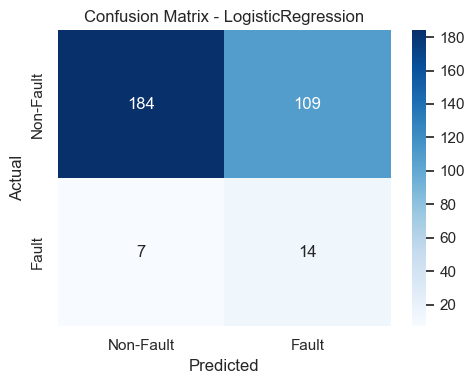

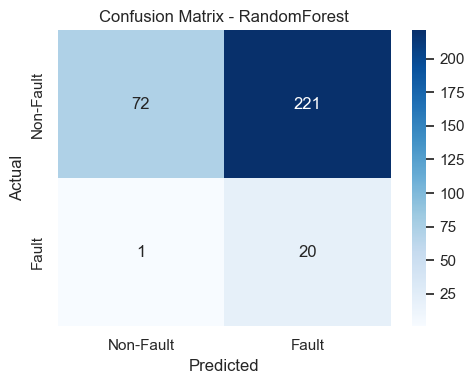

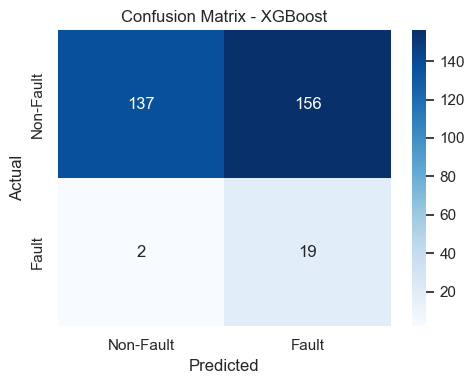

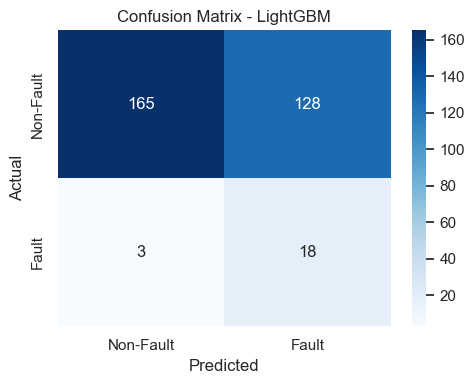

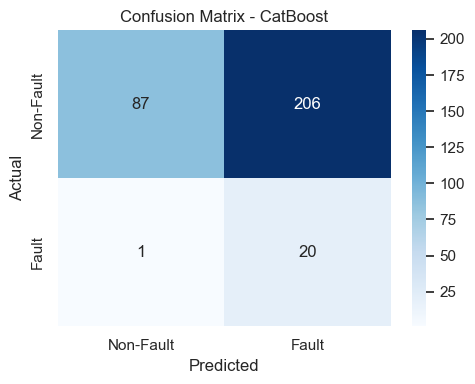

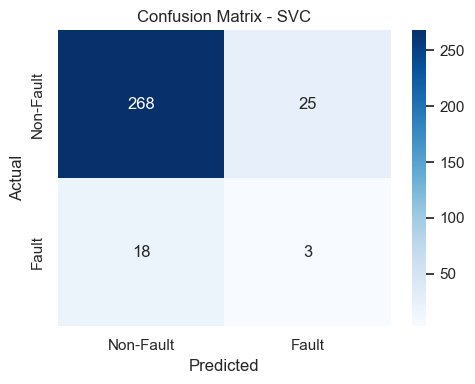

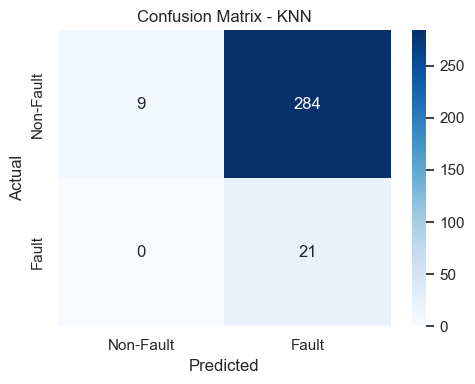

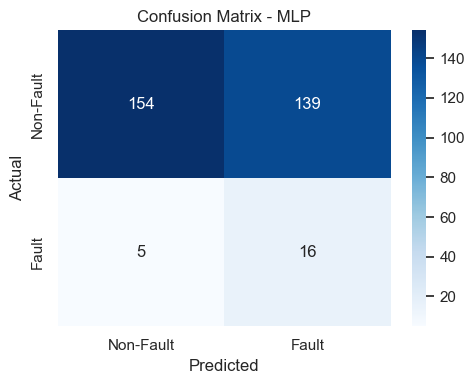

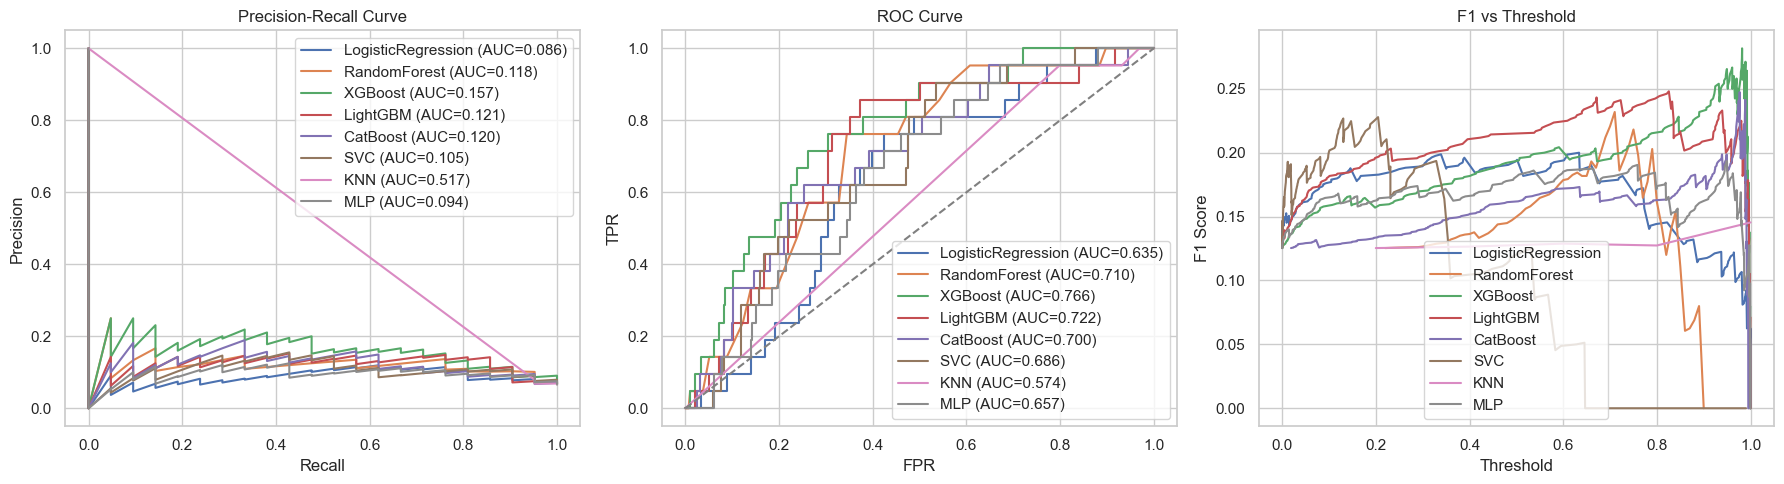


🏆 最佳模型：LightGBM（🟡 PR AUC 未達標，但 ROC AUC 與 Recall 達標 → 選預測機率最高者）
🔹 pr_auc: 0.1210
🔹 recall: 0.8571
🔹 roc_auc: 0.7224
🔹 avg_proba: 0.4546
🔹 Precision: 0.1230


In [29]:
df_results, model_scores, best_model, note = evaluate_models_and_plot(results, y_test, X.columns)

/var/folders/zc/bg3g21_j7yq8y2dpzx88kk4w0000gn/T/ipykernel_25045/1983717171.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=metric, y="Model", data=data_sorted, palette=colors[metric])
/var/folders/zc/bg3g21_j7yq8y2dpzx88kk4w0000gn/T/ipykernel_25045/1983717171.py:23: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) Arial.
  plt.tight_layout()
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


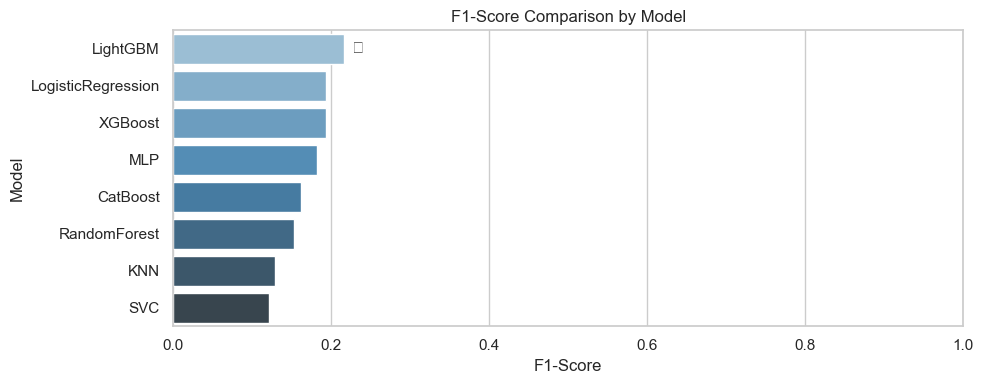

/var/folders/zc/bg3g21_j7yq8y2dpzx88kk4w0000gn/T/ipykernel_25045/1983717171.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=metric, y="Model", data=data_sorted, palette=colors[metric])
/var/folders/zc/bg3g21_j7yq8y2dpzx88kk4w0000gn/T/ipykernel_25045/1983717171.py:23: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) Arial.
  plt.tight_layout()
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


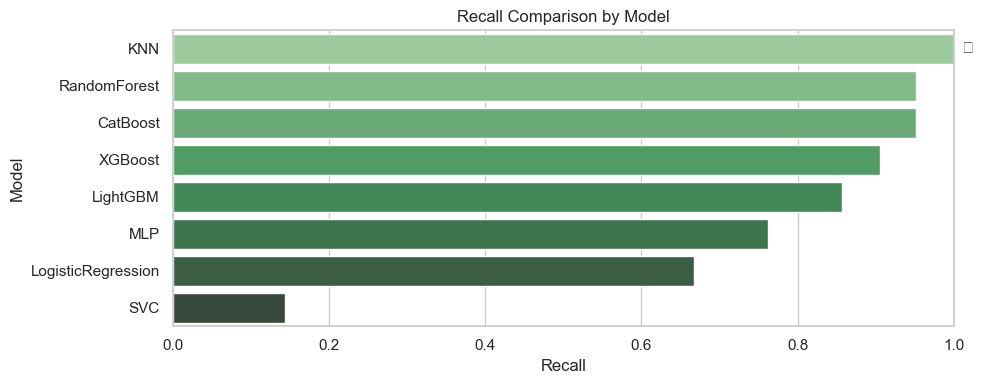

/var/folders/zc/bg3g21_j7yq8y2dpzx88kk4w0000gn/T/ipykernel_25045/1983717171.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=metric, y="Model", data=data_sorted, palette=colors[metric])
/var/folders/zc/bg3g21_j7yq8y2dpzx88kk4w0000gn/T/ipykernel_25045/1983717171.py:23: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) Arial.
  plt.tight_layout()
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


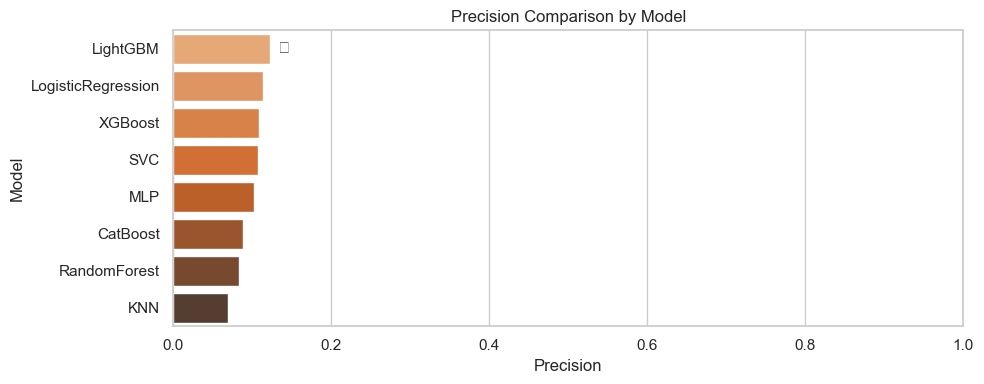

In [30]:
plot_top_metrics(df_results)